# Introduction to Machine Learning

### BUSI 520 - Python for Business Research
### Kerry Back, JGSB, Rice University

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
colors = sns.color_palette()

## Fitting and Overfitting

We have some data $x$ and $y$ and we want to use $x$ to predict $y$.  First, we'll just look at fitting a couple of models.  We'll generate some random data and fit cubic splines to it, with different numbers of knot points.

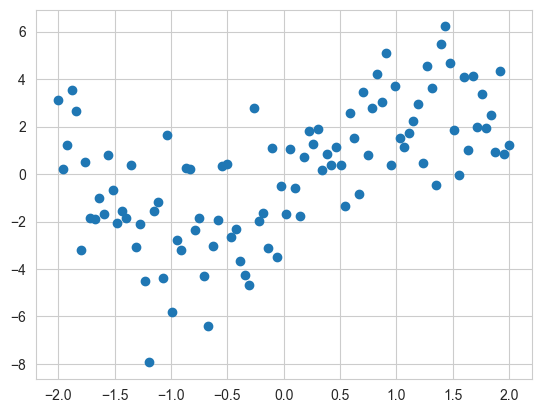

In [23]:
# Generate data
np.random.seed(0)
x = np.linspace(-2, 2, 100)
x = np.sort(x)
y = 2.9 * np.sin(1.5 * x) + 2*np.random.normal(size=100)

# View data
plt.scatter(x, y)
plt.show()

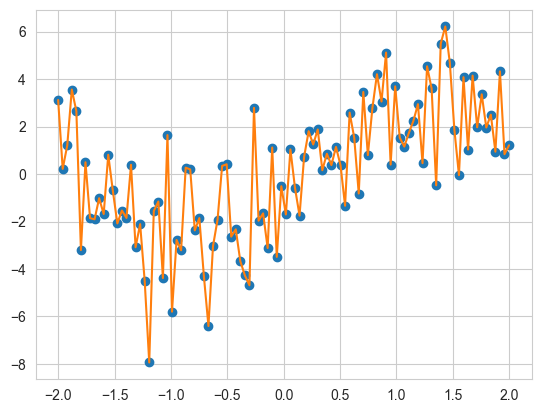

In [24]:
# fit a cubic spline through every point

from scipy.interpolate import UnivariateSpline

f1 = UnivariateSpline(x, y, s=0)
plt.scatter(x, y)
plt.plot(x, f1(x), color=colors[1])

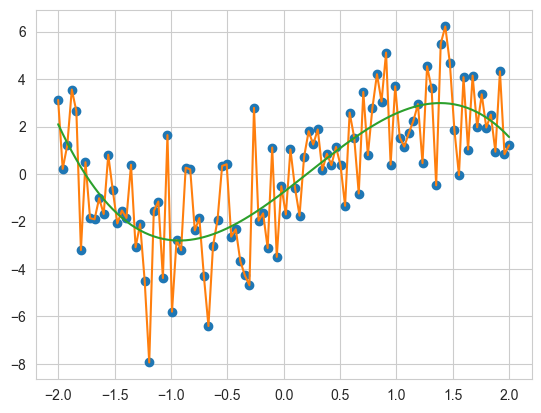

In [25]:
# allow more error in the fitting

f2 = UnivariateSpline(x, y, s=1000)
plt.scatter(x, y)
plt.plot(x, f1(x), color=colors[1])
plt.plot(x, f2(x), color=colors[2])
plt.show()

## Hyperparameters

The parameter s is a hyperparameter.  It is not fit during training.  Instead, it is set a priori.  

But we should still try to choose it optimally.

## Train and Test

Which value for s should we choose (0 or 1,000)?  We want the one that will work best on new data, i.e., out of sample.  To determine this, we can make part of our existing data "out of sample," by fitting on only a subset of the data.  

We'll train on a random subset and then test on the remainder.

In [26]:
# split into train and test

train_index = np.random.choice(range(100), 80, replace=False)
train_index = np.sort(train_index)
test_index = [i for i in range(100) if i not in train_index]
X_train = x[train_index]
y_train = y[train_index]
X_test = x[test_index]
y_test = y[test_index]

In [27]:
# train on the training data

f1 = UnivariateSpline(X_train, y_train, s=0)
f2 = UnivariateSpline(X_train, y_train, s=1000)


In [28]:
# test on the test data

y1 = f1(X_test)
y2 = f2(X_test)

MSE1 = ((y1-y_test)**2).mean()
MSE2 = ((y2-y_test)**2).mean()

Rsquared1 = 1 - MSE1 / ((y_test-y_test.mean())**2).mean()
Rsquared2 = 1 - MSE2 / ((y_test-y_test.mean())**2).mean()

print(f"MSE for s=0 is {MSE1:.2f} and MSE for s=1000 is {MSE2: .2f}")
print(f"Rsquared for s=0 is {Rsquared1:.2f} and Rsquared for s=1000 is {Rsquared2: .2f}")

MSE for s=0 is 10.39 and MSE for s=1000 is  3.25
Rsquared for s=0 is -0.14 and Rsquared for s=1000 is  0.64


What performance can we expect the model to deliver in the future?  Is the MSE or Rsquared we calculated for the optimal s an unbiased estimate of performance?

No.  The maximum over models of performance is an upward biased estimate of future performance.

To estimate future performance, we need to evaluate the model on new data - data that was not used either in training or in testing.

## Train, Validate, and Test

Split the data into three parts.  

1. Train on the training data.
2. Evaluate performance on the validation data (playing the role of the test data in our first example).  Choose the best performing model.
3. Test the performance of the chosen model on the test data (held out from training and validation).

In [29]:
# split into train, validate, and test

train_index = np.random.choice(range(100), 50, replace=False)
train_index = np.sort(train_index)
remainder = [i for i in range(100) if i not in train_index]

validate_index = np.random.choice(remainder, 30, replace=False)
validate_index = np.sort(validate_index)

test_index = [x for x in remainder if x not in validate_index]

In [30]:
X_train = x[train_index]
X_validate = x[validate_index]
X_test = x[test_index]

y_train = y[train_index]
y_validate = y[validate_index]
y_test = y[test_index]

In [31]:
# train on the training data

f1 = UnivariateSpline(X_train, y_train, s=0)
f2 = UnivariateSpline(X_train, y_train, s=1000)

In [32]:
# evaluate on the validation data

y1 = f1(X_validate)
y2 = f2(X_validate)

MSE1 = ((y1-y_validate)**2).mean()
MSE2 = ((y2-y_validate)**2).mean()

s_star = 0 if MSE1 < MSE2 else 1000
f = f1 if MSE1 < MSE2 else f2

print(f"s_star = {s_star} ")

s_star = 1000 


In [33]:
# test on the test data

y = f(X_test)
MSE = ((y-y_test)**2).mean()

## Cross Validation

Instead of splitting the 80 non-test data points into Train and Validate, cross-validation does the following.

Split the 80 points into, for example, 5 randomly chosen subsets $A, B, C, D$, and $E$.

* Use $A \cup B \cup C \cup D$ as training data and validate on $E$.  
* Then use $B \cup C \cup D \cup E$ as training data and validate on $A$.  
* Then, ..., until we have trained and validated 5 times.

Average the 5 validation scores for each model.  Choose the model with the highest average validation score.  Then test it.

## Supervised and unsupervised learning

* Supervised means choose parameters to maximize or minimize some objective
* Unsupervised is everything else (like principal components)

## Classification and regression

* Regression means trying to predict a continuous variable (not necessarily linear)
* Classification can be binary (yes or no) or multi-class

## Some models for classification and regression

* linear and penalized regression (including logit) - OLS, lasso, ridge, elastic net
* Forests - random forests and boosted forests
* Neural networks
* Support vector machines, k-nearest neighbors, ...

## Penalized linear regression example

* Lasso, ridge, and elastic net
* Hyperparameters: how much to penalize
* Cross validation and testing

In [34]:
# Generate 50 features (predictors)
np.random.seed(0)
x = np.random.normal(size=(100, 50))
X = pd.DataFrame(x, columns = [f"feature_{i}" for i in range(50)])

# Generate target 
y = X["feature_0"] + np.random.normal(size=100)

# Split into train and test (cross-validate on train)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=0
)

## Lasso

OLS minimizes the mean squared error.  Lasso is an example of penalized linear regression.  It chooses coefficients to minimize

$$\frac{1}{2}\text{MSE} + \text{penalty} \times \sum_{i=1}^n |\beta_i|$$

The penalty is a hyperparameter.  It is called "alpha" (not the regression intercept).

The larger the penalty, the smaller the estimated betas will be.  For large alpha, the estimated betas will be zeros.

Lasso is a way to do "automatic feature selection."  Features are variables used to predict.  Dropping variables with zero lasso betas may be a reasonable thing to do in some settings.

## Ridge regression

In ridge regression, the coefficients are chosen to minimize
$$\text{SSE} + \text{penalty} \times \sum_{i=1}^n \beta_i^2$$
Again, the penalty is called "alpha."

Lasso will often force some coefficients to zero.  Ridge regression is unlikely to do so, because the marginal penalty goes to zero as the coefficient goes to zero.

## Elastic net

An elastic net combines the lasso and ridge penalties.  It chooses coefficients to minimize
$$\frac{1}{2} \text{MSE} + \text{alpha} \times \text{l1\_ratio} \times \sum_{i=1}^n |\beta_i| + 
\text{alpha} \times (1 - \text{l1\_ratio}) \sum_{i=1}^n \beta_i^2$$

The sum of absolute values penalty is called an $\ell^1$ penalty.  The sum of squares is called an $\ell^2$ penalty.

## Grid Search CV

scikit-learn's GridSearchCV will do cross validation for hyperparameters on a grid that you choose.

After cross validating, it chooses the best hyperparameter combination and refits the model on all of the training data.  It is then ready to test on the testing data.

We will do lasso regression as an example.

In [35]:
alphas = (0.01, 0.1, 1, 10)

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(
    Lasso(),
    param_grid = {"alpha": alphas}
)
cv.fit(X_train, y_train)
print(f"best alpha is {cv.best_params_}")
print(f"score on the test data is {cv.score(X_test, y_test)}")

best alpha is {'alpha': 0.1}
score on the test data is 0.4933083647939911


What does the score mean?

Let's fit the model directly on the training data, using the best hyperparameter value, and compute the R-squared on the test data.

In [36]:
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

y = model.predict(X_test)
MSE = ((y-y_test)**2).mean()
Rsquared = 1 - MSE / ((y_test - y_test.mean())**2).mean()
Rsquared

0.4933083647939911

Another way to get the R-squared on the test data from the fitted model:

In [37]:
model.score(X_test, y_test)

0.4933083647939911

And we can see the regression coefficients for the 50 features.

In [38]:
model.coef_

array([ 0.96663734,  0.18871423,  0.15468459, -0.06057873, -0.        ,
       -0.        , -0.        , -0.04881431, -0.        ,  0.12474074,
        0.        ,  0.        , -0.13441716,  0.00602442, -0.        ,
       -0.        , -0.        ,  0.        , -0.03542298, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.0546803 , -0.00694504,  0.        ,
        0.09242484,  0.        , -0.0742942 , -0.        , -0.02200176,
        0.        , -0.02614745,  0.        , -0.        , -0.        ,
        0.23154105, -0.        ,  0.        ,  0.06305185,  0.        ,
        0.00691199, -0.02314481,  0.        , -0.        , -0.        ])

In [39]:
model = Lasso(alpha=0.001)
model.fit(X_train, y_train)

y = model.predict(X_test)
print(f"R-squared on the test data is {model.score(X_test, y_test)}")
model.coef_

R-squared on the test data is 0.2996228154881557


array([ 1.27278330e+00,  2.14438336e-01,  2.21474937e-01, -2.75085622e-01,
       -1.33132250e-01, -0.00000000e+00, -2.33513158e-01, -2.07911519e-01,
        6.01648206e-02,  1.43909330e-01,  1.51148027e-01,  9.52834007e-04,
       -3.16835843e-01,  3.19398137e-01, -1.47203715e-01, -0.00000000e+00,
       -2.06503303e-02,  5.27348181e-02, -8.60891154e-02, -1.13716918e-01,
       -6.64776319e-02,  2.90056474e-02, -1.38606806e-02, -9.84074784e-02,
       -5.94698913e-02,  5.61639535e-02, -1.86205337e-01, -3.20522568e-02,
       -6.56337527e-02,  1.89038191e-01,  2.26330410e-01, -1.08557559e-01,
       -2.24240808e-01, -1.74307160e-01, -8.88828616e-02,  1.44100253e-01,
       -2.71483541e-01, -7.21092096e-02, -2.61349969e-03, -3.39106554e-02,
        2.08725778e-01, -1.53548365e-01,  1.80332559e-01,  2.56784557e-01,
       -4.83819486e-02, -2.74225946e-02, -7.03116397e-02,  2.68086330e-02,
       -3.39481354e-02,  9.14877320e-02])

In [40]:
alphas = np.logspace(-3, 0, 20)
train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))


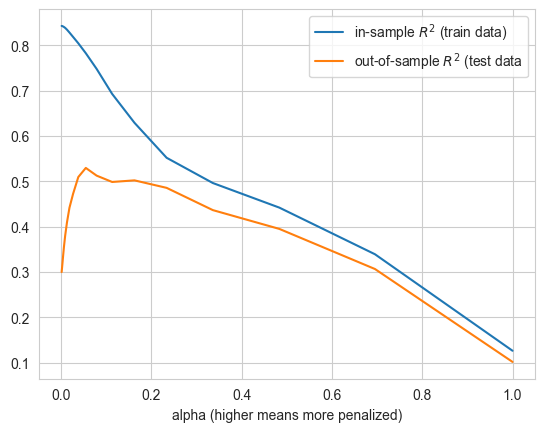

In [41]:
plt.plot(alphas, train_scores, label=r"in-sample $R^2$ (train data)")
plt.plot(alphas, test_scores, label=r"out-of-sample $R^2$ (test data")
plt.xlabel("alpha (higher means more penalized)")
plt.legend()
plt.show()

## Exercise

Run GridSearchCV for ridge regression and find the out-of-sample $R^2$ for the best alpha value.

Import Ridge as

    from sklearn.linear_model import Ridge

best alpha is {'alpha': 10}
score on the test data is 0.43876563823114767
R-squared on the test data is 0.43876563823114767
best alpha is {'alpha': 29.763514416313193}
score on the test data is 0.45756120584016924


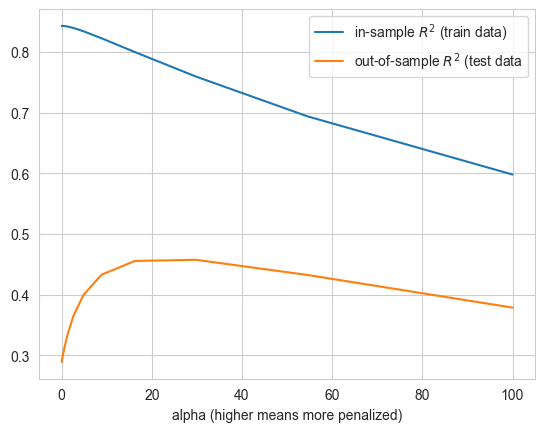

In [52]:
from sklearn.linear_model import Ridge
alphas = (0.01, 0.1, 1, 10)


cv = GridSearchCV(
    Ridge(),
    param_grid = {"alpha": alphas}
)
cv.fit(X_train, y_train)
print(f"best alpha is {cv.best_params_}")
print(f"score on the test data is {cv.score(X_test, y_test)}")

model = Ridge(alpha=10)
model.fit(X_train, y_train)

y = model.predict(X_test)
print(f"R-squared on the test data is {model.score(X_test, y_test)}")
model.coef_

alphas = np.logspace(-3, 2, 20)
train_scores = []
test_scores = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

cv = GridSearchCV(
    Ridge(),
    param_grid = {"alpha": alphas}
)
cv.fit(X_train, y_train)
print(f"best alpha is {cv.best_params_}")
print(f"score on the test data is {cv.score(X_test, y_test)}")

plt.plot(alphas, train_scores, label=r"in-sample $R^2$ (train data)")
plt.plot(alphas, test_scores, label=r"out-of-sample $R^2$ (test data")
plt.xlabel("alpha (higher means more penalized)")
plt.legend()
plt.show()


## Elastic net example

This provides an example of searching over a two-dimensional grid of hyperparameter values.

In [55]:
from sklearn.linear_model import ElasticNet 
param_grid = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
}
cv = GridSearchCV(
    ElasticNet(),
    param_grid = param_grid
)
cv.fit(X_train, y_train)
print(f"best parameters are {cv.best_params_}")
print(f"score on the test data is {cv.score(X_test, y_test)}")


model=ElasticNet(alpha=.1,l1_ratio=0.9)
model.fit(X_train,y_train)
y=model.predict(X_test)
print(f"rsquare is {model.score(X_test,y_test)}")


model.coef_



best parameters are {'alpha': 0.1, 'l1_ratio': 0.9}
score on the test data is 0.4958502179743399
rsquare is 0.4958502179743399


array([ 0.96795154,  0.19729486,  0.16545743, -0.06968463, -0.        ,
       -0.        , -0.00251728, -0.05851713, -0.        ,  0.13106549,
        0.        ,  0.        , -0.140202  ,  0.02323325, -0.00731521,
        0.        , -0.        ,  0.        , -0.04188324, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.06041364, -0.01766639,  0.00612928,
        0.09966924,  0.        , -0.08434436, -0.00480259, -0.0297395 ,
        0.        , -0.03998194,  0.        , -0.        , -0.        ,
        0.2375543 , -0.        ,  0.        ,  0.07256689,  0.        ,
        0.01105655, -0.03203352,  0.        , -0.        , -0.        ])

## Question

What are the regression coefficients when the model with the best hyperparameters is fit on the training data?